<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/7_Using_more_sophisticated_images_with_convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using more sophisticated images with convolutional Neural Networks

여기서는 개와 고양이로 이루어진 real images들을 인식할 것이다.  
현실에서의 데이터는 지저분하기도 하고 모양이 전부 재각각이기도 하다.
  
다음의 step으로 이미지 분석기를 만들어보자.
1. Explore the Example Data of Cats and Dogs
2. Build and Train a Neural Network to recognize the difference between the two
3. Evaluate the Training and Validation accuracy

## Explore the Eaxample Date

다음의 'Dogs vs Cats dataset'는 25000개의 이미지를 포함한 kaggle 데이터이다.

In [4]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2021-01-03 05:07:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   218MB/s    in 0.3s    

2021-01-03 05:07:06 (218 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

여기서 핵심은 ImageGenerator를 사용해서 우리가 직접 dog과 cat으로 라벨링하지 않는다는 것이다.(ImageGenerator는 하위 directory를 읽어주는 코드이다. 하위 directory를 읽고 directory이름에서 자동으로 이름을 매칭시킨다.)

In [7]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [8]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.64.jpg', 'cat.179.jpg', 'cat.520.jpg', 'cat.381.jpg', 'cat.990.jpg', 'cat.597.jpg', 'cat.68.jpg', 'cat.631.jpg', 'cat.629.jpg', 'cat.745.jpg']
['dog.520.jpg', 'dog.674.jpg', 'dog.37.jpg', 'dog.191.jpg', 'dog.304.jpg', 'dog.301.jpg', 'dog.987.jpg', 'dog.744.jpg', 'dog.761.jpg', 'dog.723.jpg']


In [11]:
print('total training cat images : ', len(os.listdir(train_cats_dir)))
print('total training dog images : ', len(os.listdir(train_dogs_dir)))

print('total validation cat images : ', len(os.listdir(validation_cats_dir)))
print('total validation dog images : ', len(os.listdir(validation_dogs_dir)))

total training cat images :  1000
total training dog images :  1000
total validation cat images :  500
total validation dog images :  500


이해를 돕기위해 몇 개의 사진들만 확인한 후 넘어가도록 하자.

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

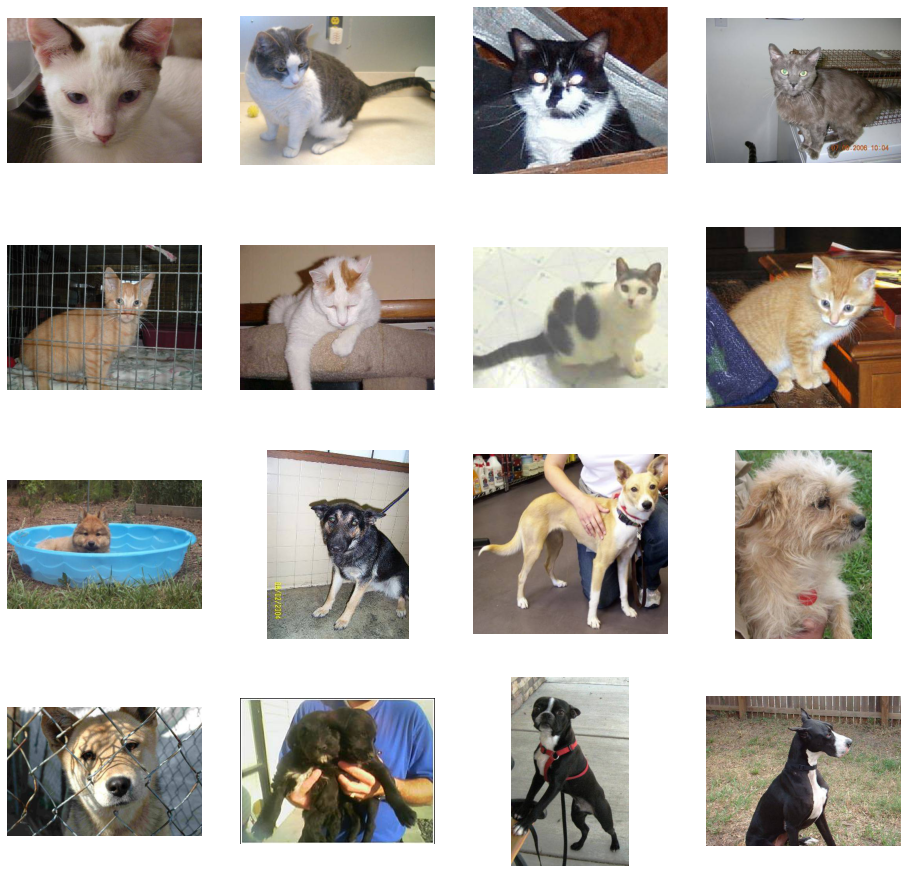

In [21]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[pic_index -8: pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[pic_index -8: pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix) :
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch to Get to ~72% Accuracy

In [22]:
import tensorflow as tf

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [27]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(lr = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

## Data Preprocessing

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
train_datagen = ImageDataGenerator(rescale = 1. /255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training

In [33]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 15,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/15
100/100 - 56s - loss: 0.8012 - acc: 0.5605 - val_loss: 0.6968 - val_acc: 0.5140
Epoch 2/15
100/100 - 55s - loss: 0.6509 - acc: 0.6555 - val_loss: 0.6639 - val_acc: 0.6110
Epoch 3/15
100/100 - 55s - loss: 0.5621 - acc: 0.7200 - val_loss: 0.6043 - val_acc: 0.6820
Epoch 4/15
100/100 - 55s - loss: 0.4578 - acc: 0.7920 - val_loss: 0.6355 - val_acc: 0.7020
Epoch 5/15
100/100 - 55s - loss: 0.3728 - acc: 0.8380 - val_loss: 0.6092 - val_acc: 0.7370
Epoch 6/15
100/100 - 55s - loss: 0.2915 - acc: 0.8725 - val_loss: 0.9330 - val_acc: 0.6430
Epoch 7/15
100/100 - 55s - loss: 0.1998 - acc: 0.9190 - val_loss: 0.9703 - val_acc: 0.6790
Epoch 8/15
100/100 - 55s - loss: 0.1477 - acc: 0.9390 - val_loss: 0.8851 - val_acc: 0.7000
Epoch 9/15
100/100 - 55s - loss: 0.0928 - acc: 0.9675 - val_loss: 1.2104 - val_acc: 0.6950
Epoch 10/15
100/100 - 55s - loss: 0.0706 - acc: 0.9775 - val_loss: 1.5754 - val_acc: 0.7050
Epoch 11/15
100/100 - 55s - loss: 0.0514 - acc: 0.9835 - val_loss: 1.5149 - val_acc: 0.72

## Running the Model

In [35]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

In [37]:
uploaded = files.upload()

for fn in uploaded.keys() :
  path = '/content/' + fn
  img = image.load_img(path, target_size = (150, 150))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size = 10)

  print(classes[0])

  if classes[0] > 0.5 :
    print(fn + ' is a dog')
  else : 
    print(fn + ' is a cat')

Saving dog-2785074_640.jpg to dog-2785074_640.jpg
[1.]
dog-2785074_640.jpg is a dog


## Visualizing Intermediate Representations

In [38]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [42]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size = (150, 150))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


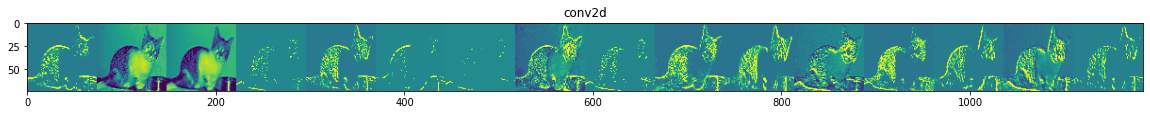

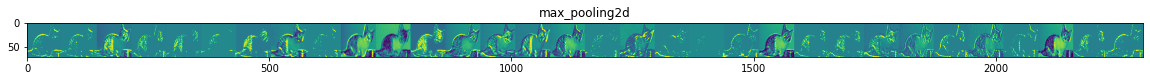

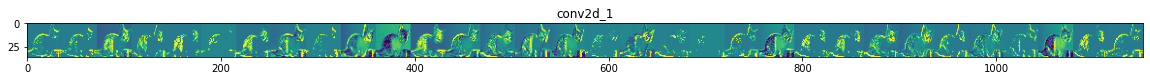

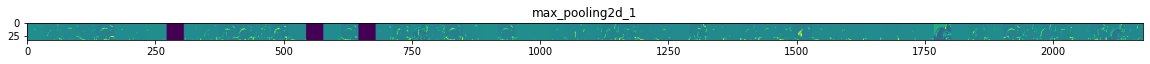

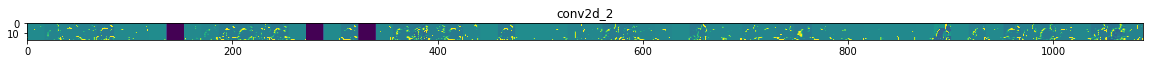

In [45]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps) :
  if len(feature_map.shape) == 4 :
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]

    display_grid = np.zeros((size, size*n_features))

    for i in range(n_features) :
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      display_grid[:, i*size : (i+1)*size] = x

    scale = 20. / n_features
    plt.figure(figsize = (scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

## Evaluating Accuracy and Loss for the Model

training과정 중 수집된(collected) training/validation accurray & loss를 plotting해보자

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

Text(0.5, 1.0, 'Training and Validation Loss')

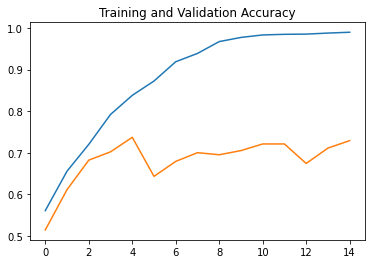

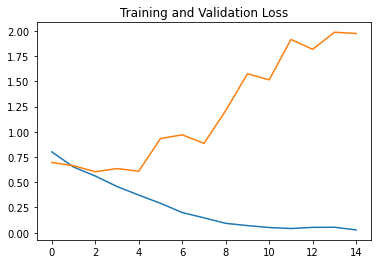

In [48]:
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss')

* Training Accuracy는 100%에 가까운 반면 Validation Accuracy는 70% 수준에 머물러 있는 것으로 보아 training data에 Overfitting되어있음을 알 수 있다.
* 상대적으로 적은 수의 training data(2000)를 가지기 있기 때문에 overfitting을 항상 조심해야 한다.(Overfitting : 적은 수의 예제를 바탕으로 일반화 되지 않는 패턴을 학습할 때 발생한다.)
* 다음과제를 학습하면서 Overfitting을 어떻게 방지할 수 있는지 알아보자!